In [1]:
# Standard python libraries
import os
import requests
import pickle
# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import shap
shap.initjs()

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

from lightautoml.addons.interpretation import SSWARM

## Notebook with the implementation of the SSWARM algorithm for finding shapley values

In [2]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 100
TARGET_NAME = 'TARGET'
np.random.seed(RANDOM_STATE)

In [3]:
DATASET_DIR = '../data/'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/AILab-MLTools/LightAutoML/master/examples/data/sampled_app_train.csv'

### Binary

In [4]:
%%time
if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)
data = pd.read_csv(DATASET_DIR + DATASET_NAME)

train_data, test_data = train_test_split(
    data, 
    test_size=TEST_SIZE, 
    stratify=data[TARGET_NAME], 
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

# task = Task('binary')

# roles = {
#     'target': TARGET_NAME,
#     'drop': ['SK_ID_CURR']
# }

# automl = TabularAutoML(
#     task = task, 
#     timeout = TIMEOUT,
#     cpu_limit = N_THREADS,
#     reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
# )

# out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 0)

Data is splitted. Parts sizes: train_data = (8000, 122), test_data = (2000, 122)
CPU times: user 149 ms, sys: 44.4 ms, total: 193 ms
Wall time: 191 ms


In [5]:
# with open('automl.pkl', 'wb') as f:
#     pickle.dump(automl, f)

In [6]:
with open('automl.pkl', 'rb') as f:
    automl = pickle.load(f)

In [7]:
train_data.shape

(8000, 122)

In [8]:
len(automl.collect_used_feats())

109

#### 
**Get shapley values of the model**

In [9]:
explainer = SSWARM(automl, random_state=RANDOM_STATE)

In [10]:
%%time
shap_values = explainer.shap_values(test_data, n_jobs=N_THREADS)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:12<00:00, 13.87it/s]


CPU times: user 1min 35s, sys: 6.95 s, total: 1min 42s
Wall time: 1min 14s


In [11]:
shap_values.shape

(2, 2000, 109)

In [17]:
automl.reader.dropped_features

['SK_ID_CURR',
 'TARGET',
 'FLAG_MOBIL',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

In [13]:
explainer.used_feats

['CNT_CHILDREN',
 'FLAG_OWN_CAR',
 'BASEMENTAREA_AVG',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_14',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'ENTRANCES_MODE',
 'DAYS_LAST_PHONE_CHANGE',
 'YEARS_BUILD_MEDI',
 'LIVINGAPARTMENTS_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'FLAG_DOCUMENT_16',
 'NONLIVINGAREA_MEDI',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'CODE_GENDER',
 'COMMONAREA_AVG',
 'AMT_ANNUITY',
 'ENTRANCES_MEDI',
 'HOUR_APPR_PROCESS_START',
 'NAME_HOUSING_TYPE',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_2',
 'DAYS_ID_PUBLISH',
 'FLAG_CONT_MOBILE',
 'HOUSETYPE_MODE',
 'FONDKAPREMONT_MODE',
 'FLOORSMAX_MODE',
 'FLAG_EMAIL',
 'WALLSMATERIAL_MODE',
 'ENTRANCES_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'ELEVATORS_AVG',
 'FLAG_DOCUMENT_18',
 'OWN_CAR_AGE',
 'REG_REGION_NOT_WORK_REGION',
 'DAYS_REGISTRATION',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_AVG',
 'NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'LIVINGAPARTMENTS

In [12]:
test_data[explainer.used_feats]

CNT_CHILDREN FLAG_OWN_CAR  BASEMENTAREA_AVG  DEF_30_CNT_SOCIAL_CIRCLE  \
3898             0            N               NaN                       0.0   
4882             0            N            0.0759                       0.0   
3845             1            Y            0.0416                       0.0   
9517             0            Y            0.0533                       0.0   
5592             0            N            0.2923                       0.0   
...            ...          ...               ...                       ...   
8218             2            Y               NaN                       0.0   
5733             0            N            0.0515                       3.0   
4179             1            N               NaN                       0.0   
1514             0            N            0.0776                       1.0   
6694             0            N               NaN                       0.0   

      FLAG_DOCUMENT_14  AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
3898                 0                        0.0                         0.0   
4882                 0                        0.0                         0.0   
3845                 0                        0.0                         0.0   
9517                 0                        0.0                         0.0   
5592                 0                        0.0                         0.0   
...                ...                        ...                         ...   
8218                 0                        0.0                         0.0   
5733                 0                        0.0                         0.0   
4179                 0                        0.0                         0.0   
1514                 0                        0.0                         0.0   
6694                 0                        0.0                         0.0   

      ENTRANCES_MODE  DAYS_LAST_PHONE_CHANGE  YEARS_BUILD_MEDI  ...  \
3898             NaN                  -462.0               NaN  ...   
4882          0.0345                     0.0            0.6981  ...   
3845          0.0345                  -663.0            0.7451  ...   
9517          0.0690                  -962.0            0.8658  ...   
5592          0.0345                    -4.0            0.7786  ...   
...              ...                     ...               ...  ...   
8218             NaN                     0.0               NaN  ...   
5733          0.0345                 -1012.0            0.8390  ...   
4179             NaN                  -506.0               NaN  ...   
1514          0.0345                 -1554.0               NaN  ...   
6694             NaN                  -739.0               NaN  ...   

      YEARS_BEGINEXPLUATATION_MEDI  APARTMENTS_AVG  NAME_TYPE_SUITE  \
3898                           NaN             NaN    Unaccompanied   
4882                        0.9776          0.1505    Unaccompanied   
3845                        0.9811          0.1021    Unaccompanied   
9517                        0.9901          0.0820    Unaccompanied   
5592                        0.9836          0.4985    Unaccompanied   
...                            ...             ...              ...   
8218                        0.0000          0.0000    Unaccompanied   
5733                        0.9881          0.0825    Unaccompanied   
4179                           NaN             NaN    Unaccompanied   
1514                        0.9841          0.2155    Unaccompanied   
6694                        0.9796             NaN    Unaccompanied   

      LANDAREA_MODE  LIVINGAREA_MEDI BASEMENTAREA_MODE  BASEMENTAREA_MEDI  \
3898            NaN              NaN               NaN                NaN   
4882         0.0584           0.0618            0.0787             0.0759   
3845         0.0000           0.0867            0.0432             0.0416   
9517         0.0101           0.0851            0.0546             0.0

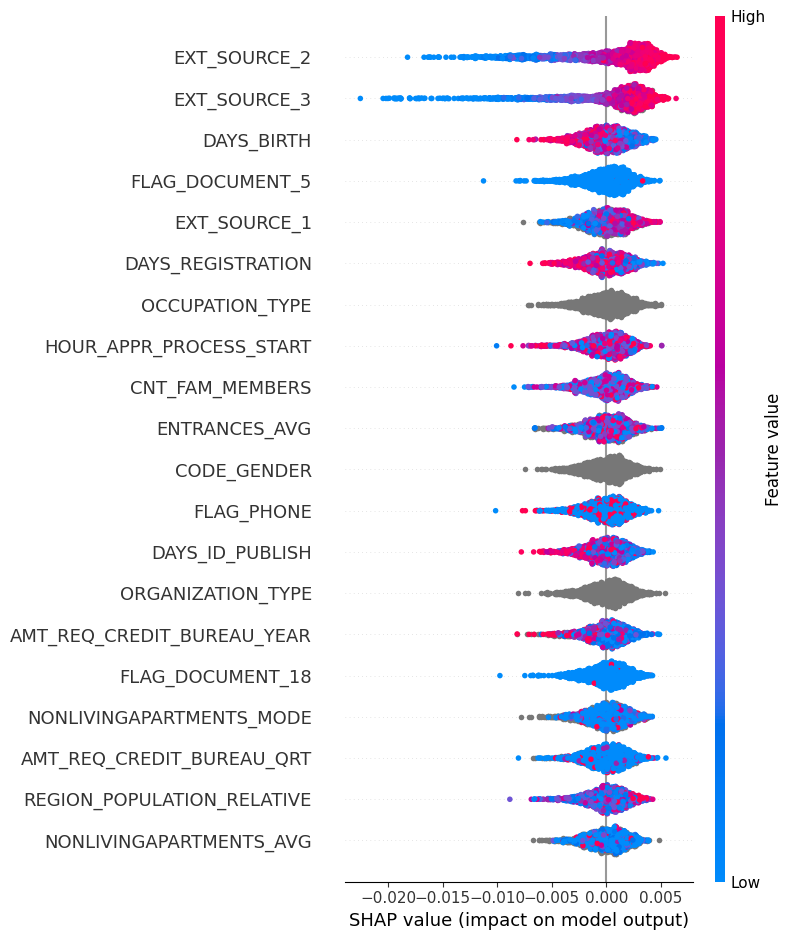

In [18]:
shap.summary_plot(shap_values[0], test_data[explainer.used_feats])

In [8]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test.iloc[:1])

In [9]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[:1])

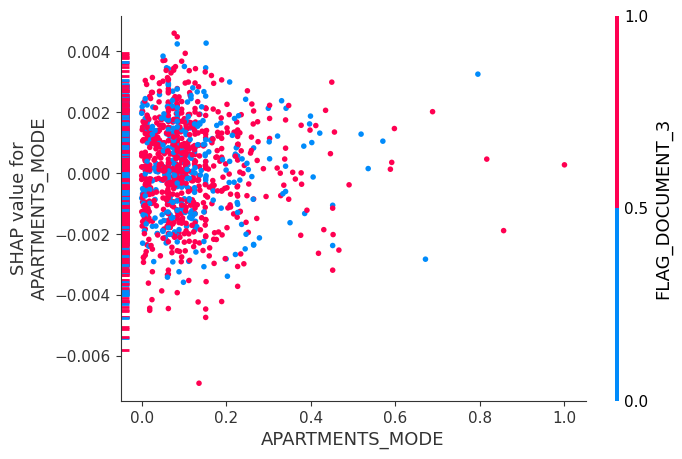

In [22]:
shap.dependence_plot("APARTMENTS_MODE", shap_values[0], test_data[explainer.used_feats], interaction_index="FLAG_DOCUMENT_3")

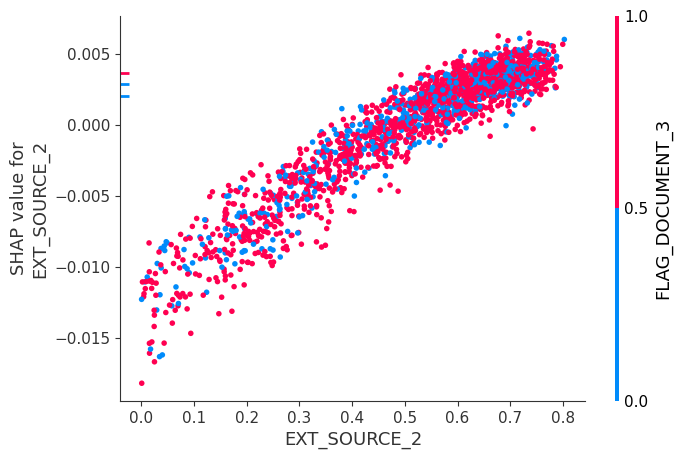

In [23]:
shap.dependence_plot("EXT_SOURCE_2", shap_values[0], test_data[explainer.used_feats], interaction_index="FLAG_DOCUMENT_3")

In [21]:
shap.dependence_plot("SK_ID_CURR", shap_values[0], test_data[explainer.used_feats], interaction_index="FLAG_DOCUMENT_3")

ValueError: Could not find feature named: SK_ID_CURR

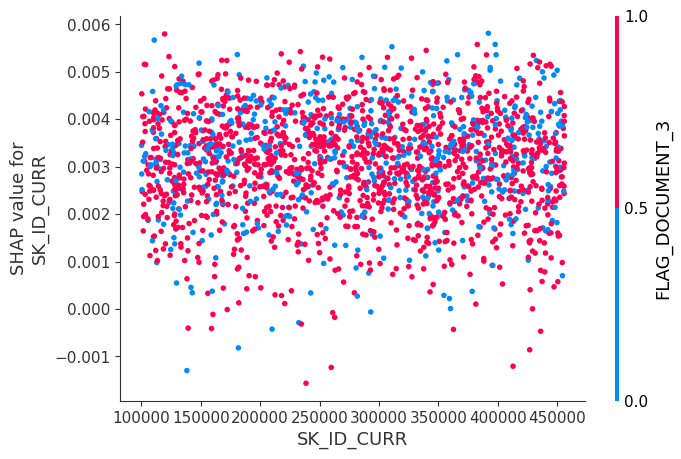

In [11]:
# shapley values for SK_ID_CURR look random and chaotic and are very close to zero
shap.dependence_plot("SK_ID_CURR", shap_values[0], X_test, interaction_index="FLAG_DOCUMENT_3")

## Regression

In [10]:
data = pd.read_csv('https://raw.githubusercontent.com/reneemarama/aiming_high_in_aimes/master/datasets/train.csv')

In [11]:
train_data, test_data = train_test_split(
    data, 
    test_size=TEST_SIZE,  
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

task = Task('reg', loss='mae', metric='mae')
roles = {
    'target': 'SalePrice',
    'drop': ['Id', 'PID']
}
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 0)

Data is splitted. Parts sizes: train_data = (1640, 81), test_data = (411, 81)


#### 
**Get shapley values of the model**

In [12]:
X_test = test_data.drop(columns=roles["target"]).reset_index(drop=True)
explainer = SSWARM(automl, random_state=RANDOM_STATE)

In [13]:
%%time
shap_values = explainer.shap_values(X_test, n_jobs=N_THREADS)

1742it [00:35, 49.36it/s]                                                                                                            


CPU times: user 4min 3s, sys: 1.57 s, total: 4min 5s
Wall time: 36.1 s


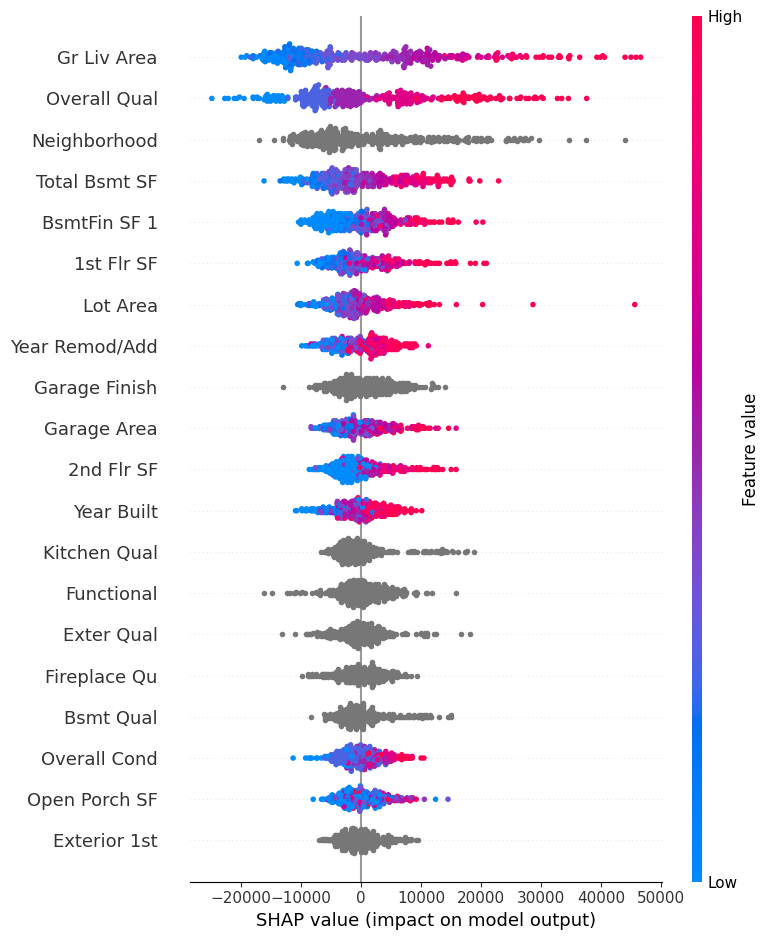

In [14]:
shap.summary_plot(shap_values, X_test)

In [15]:
shap.force_plot(explainer.expected_value, shap_values, X_test)

In [16]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[:1])

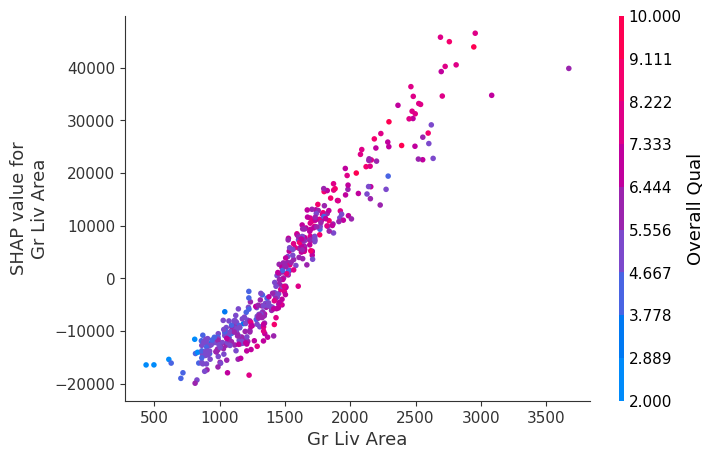

In [17]:
shap.dependence_plot("Gr Liv Area", shap_values, X_test, interaction_index="Overall Qual")

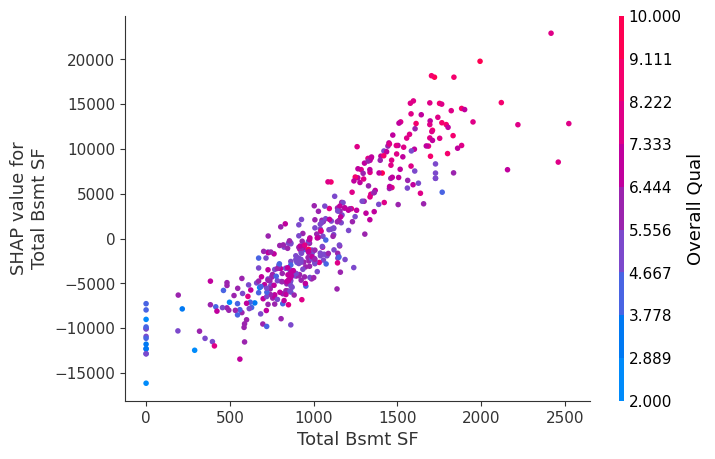

In [18]:
shap.dependence_plot("Total Bsmt SF", shap_values, X_test, interaction_index="Overall Qual")

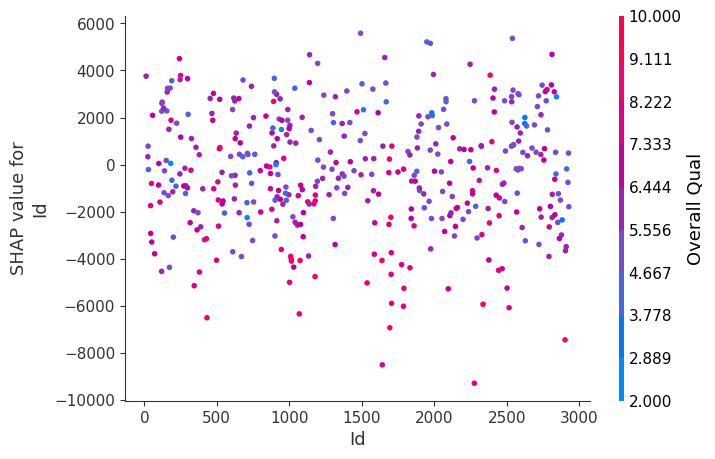

In [19]:
shap.dependence_plot("Id", shap_values, X_test, interaction_index="Overall Qual")

## Multiclass

In [24]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

data = pd.read_csv(
    ZipFile(
        BytesIO(
            urlopen(
                "https://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran%20Calls%20(MFCCs).zip"
            ).read()
        )
    ).open('Frogs_MFCCs.csv')
)

train_data, test_data = train_test_split(
    data, 
    test_size=TEST_SIZE,        
    shuffle=True, 
    random_state=RANDOM_STATE   
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')


task = Task('multiclass')
roles = {
    'target': 'Species',
    'drop': ['RecordID'] 
    
}

Data is splitted. Parts sizes: train_data = (5756, 26), test_data = (1439, 26)


In [25]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 0)

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.


#### 
**Get shapley values of the model**

In [27]:
X_test = test_data.drop(columns=roles["target"]).reset_index(drop=True)
explainer = SSWARM(automl, random_state=RANDOM_STATE)

In [28]:
%%time
shap_values = explainer.shap_values(X_test, n_jobs=N_THREADS)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.85it/s]


CPU times: user 6min 14s, sys: 2.74 s, total: 6min 17s
Wall time: 24.9 s


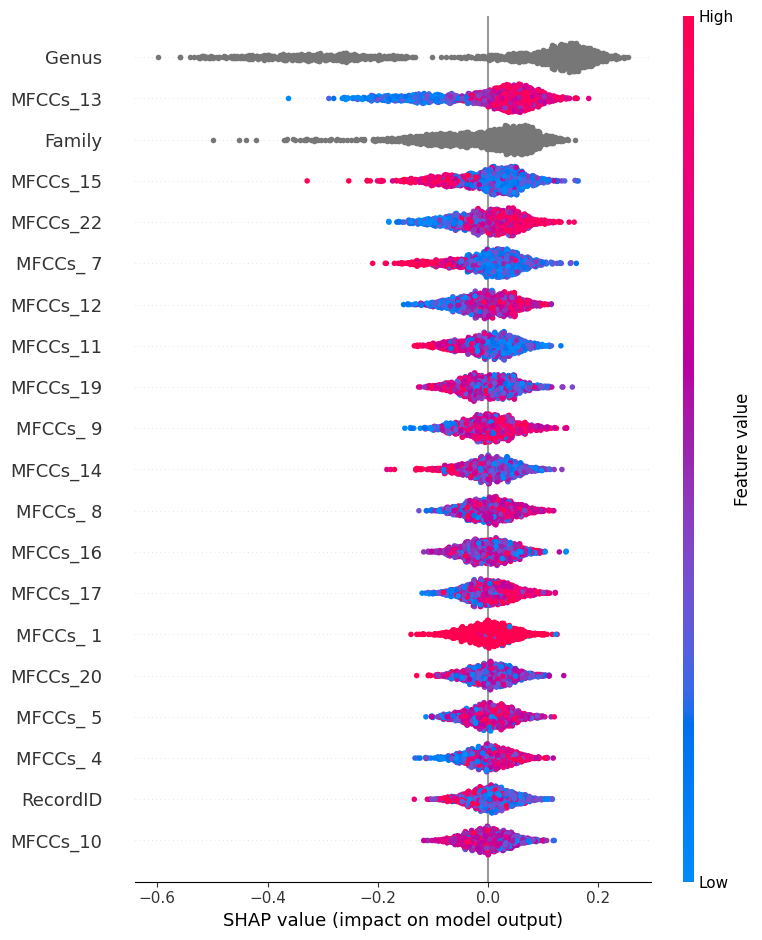

In [29]:
shap.summary_plot(shap_values[0], X_test)

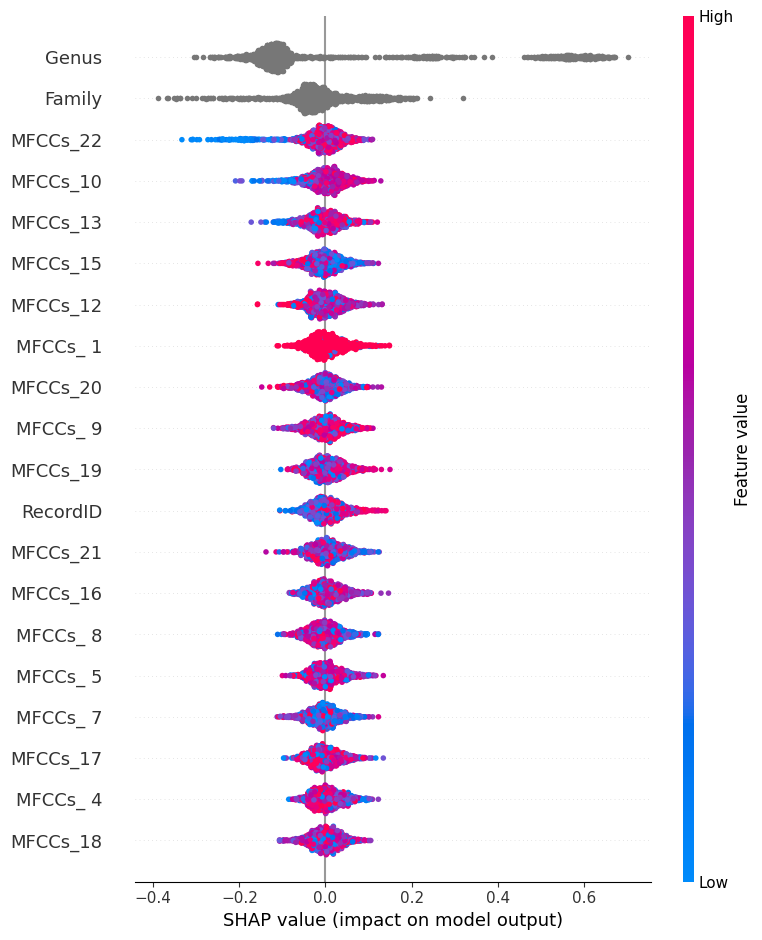

In [30]:
shap.summary_plot(shap_values[1], X_test)

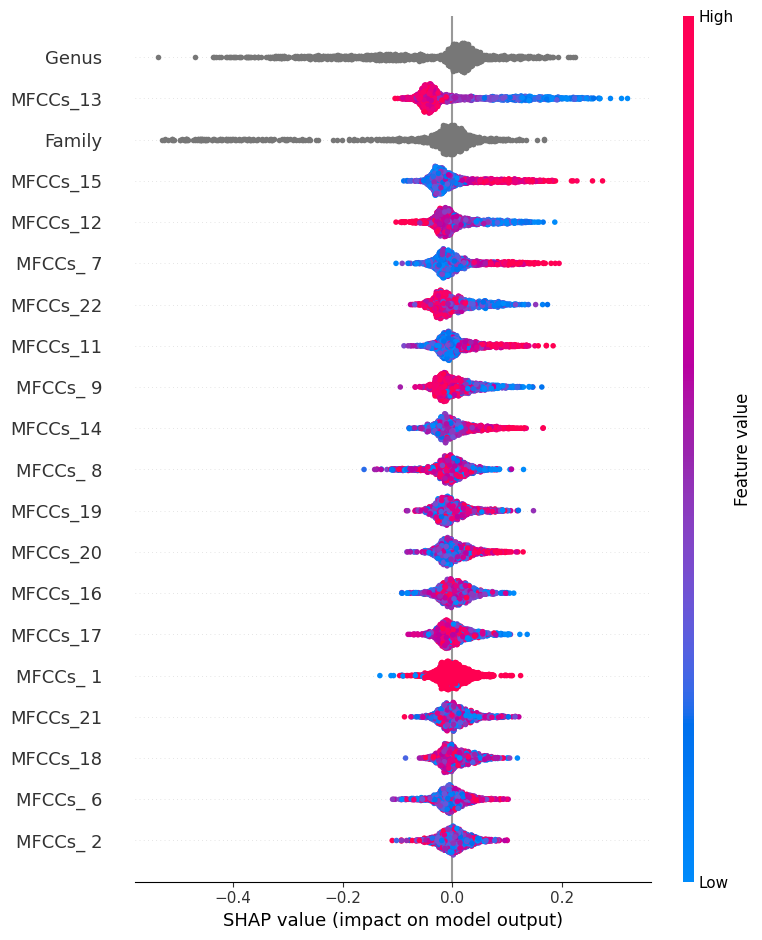

In [31]:
shap.summary_plot(shap_values[2], X_test)

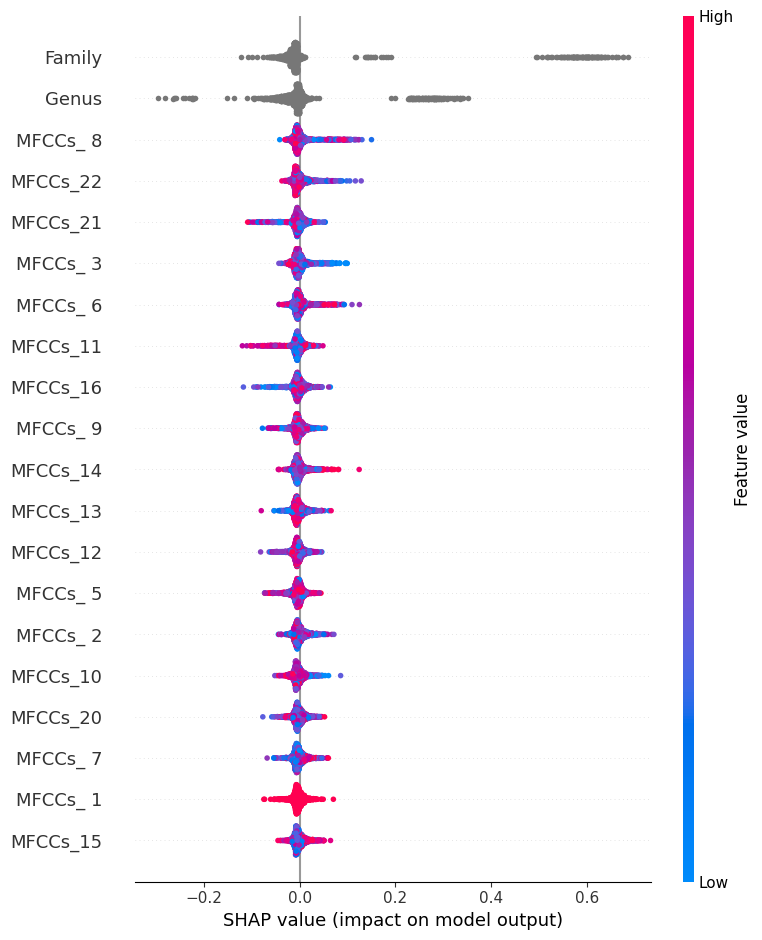

In [32]:
shap.summary_plot(shap_values[3], X_test)

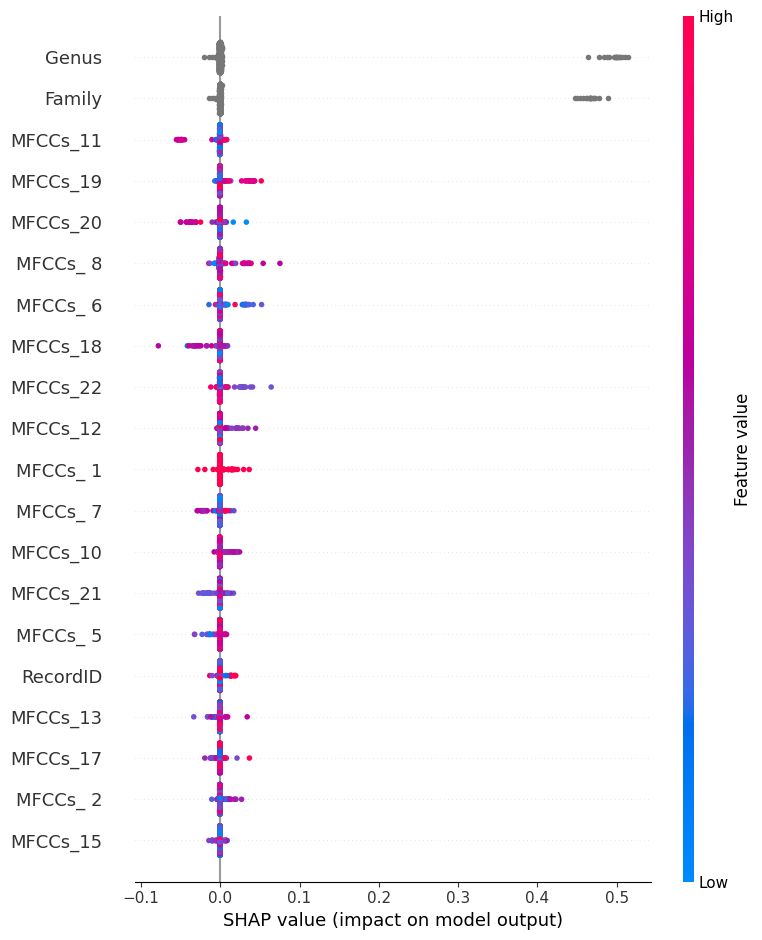

In [33]:
shap.summary_plot(shap_values[9], X_test)

In [34]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test.iloc[:1])

In [35]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[:1])

In [36]:
shap.force_plot(explainer.expected_value[2], shap_values[2][0], X_test.iloc[:1])

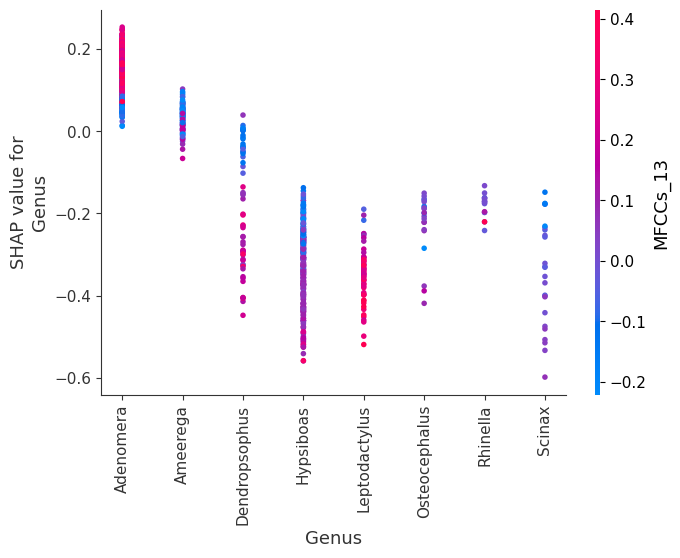

In [37]:
shap.dependence_plot("Genus", shap_values[0], X_test)

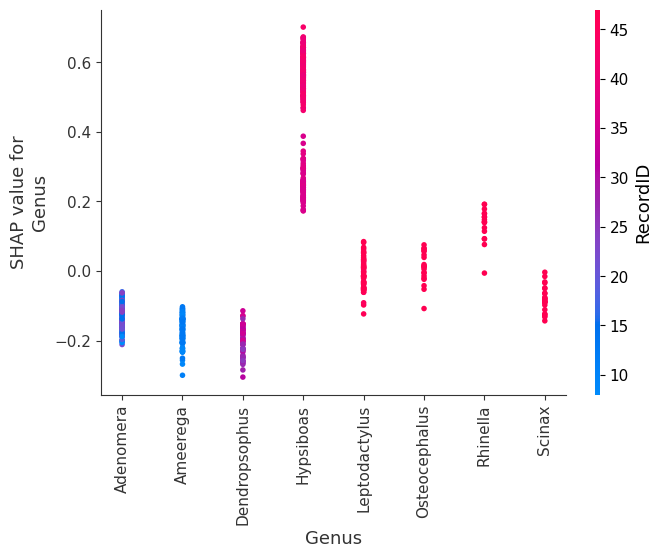

In [38]:
shap.dependence_plot("Genus", shap_values[1], X_test)

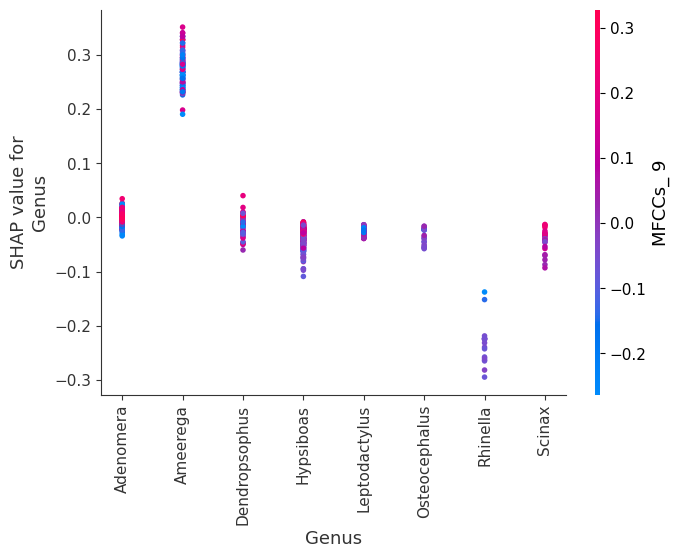

In [39]:
shap.dependence_plot("Genus", shap_values[3], X_test)

In [ ]:
shap.dependence_plot("MFCCs_13", shap_values[0], X_test)

In [ ]:
shap.dependence_plot("RecordID", shap_values[3], X_test)